In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy

from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from shapely.geometry import Point, Polygon, shape

from functools import partial

from IPython.display import GeoJSON

In [3]:
tools.set_credentials_file(username='ilyakats', api_key='Rl4Jqs5Y5dDL7amnmR1g')

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from [here](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

In [4]:
bk = pd.read_csv('C:/Temp/CUNY/data608-hw2/PLUTO17v1.1/BK2017V11.csv')
bx = pd.read_csv('C:/Temp/CUNY/data608-hw2/PLUTO17v1.1/BX2017V11.csv')
mn = pd.read_csv('C:/Temp/CUNY/data608-hw2/PLUTO17v1.1/MN2017V11.csv')
qn = pd.read_csv('C:/Temp/CUNY/data608-hw2/PLUTO17v1.1/QN2017V11.csv')
si = pd.read_csv('C:/Temp/CUNY/data608-hw2/PLUTO17v1.1/SI2017V11.csv')

ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

# Getting rid of some outliers
ny = ny[(ny['YearBuilt'] > 1850) & (ny['YearBuilt'] < 2020) & (ny['NumFloors'] != 0)]

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning:

Columns (19,20,22,23,24,25,26,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning:

Columns (19,20,22,23,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning:

Columns (19,20,22,24,26) have mixed types. Specify dtype option on import or set low_memory=False.

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning:

Columns (19,20,22,23,64,65,77) have mixed types. Specify dtype option on import or set low_memory=False.

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning:

Columns (19,20,22,24,64,65,80) have mixed types. Specify dtype option on import or set l

I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [5]:
wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 "
            "+lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 "
            "+ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
ny['XCoord'] = 0.3048*ny['XCoord']
ny['YCoord'] = 0.3048*ny['YCoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['XCoord'].values, ny['YCoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and [2D histograms](https://plot.ly/python/2D-Histogram/) (also check out their close relatives: [2D density plots](https://plot.ly/python/2d-density-plots/) and the more general form: [heatmaps](https://plot.ly/python/heatmaps/).

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [7]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('YearBuilt').count()['BBL'].index,
    y = ny.groupby('YearBuilt').count()['BBL']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig, filename = 'ny-year-built')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~ilyakats/0 or inside your plot.ly account where it is named 'ny-year-built'


Something looks off... You're going to have to deal with this imperfect data to answer this first question. 

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

---

Hello all, here are some pandas tips to help you guys through this homework:

[Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/indexing.html): .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

[Group By](https://pandas.pydata.org/pandas-docs/stable/groupby.html):  This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a [reset_index()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html).

[Reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html): I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a [huge section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) on datetime indexing. In particular, check out [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), which provides time series specific aggregation.

[Merging, joining, and concatenation](https://pandas.pydata.org/pandas-docs/stable/merging.html): There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

---

### Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

### Solution

Per data dictionary, _YearBuilt_ is accurate for the decade, but not necessarily for the specific year. Therefore, year of construction will be binned by decade. Construction year ranges from 1851 to 2017; however, values from the 19th century are unrealible. Anything built prior to 1910, is included in the bin for 1910. 

Number of floors, _NumFloors_, ranges from 0 to 119. There is significantly more short buildings than tall ones. As such I have selected the following bins: individual floors up to 10, aggregated by 5 floors from 10 to 50, aggregated by 10 floors from 50 to 90 and then a single bin for anything over 90. 

The heatmap showing number of buildings per decade and with a certain number of floors is displayed on a log scale.

One potentially big issue of this visualization is different bin size/scale of the Y axis (number of floors). I still think it is simple to understand and informative enough to include; however, I would prefer to include horizontal dashed lines where the categories meet (at '10' floors and '50' floors). Unfortunately, I could not figure out how to overlay lines onto the heatmap.

Please note that I only have basic knowledge of Python, pandas and numpy, so the code below is less elegant than it should be. I have concentrated my work on getting visualizations to work.

In [8]:
# Bins for YearBuilt - by decade
yearbins = np.append([1850], np.arange(1910, 2030, 10))
yearBuiltCut = pd.cut(ny['YearBuilt'], yearbins)

# Bins for NumFloors
floorbins = np.arange(0, 10, 1)
floorbins = np.append(floorbins, np.arange(10, 50, 5))
floorbins = np.append(floorbins, np.arange(50, 100, 10))
floorbins = np.append(floorbins, [120])
numFloorsCut = pd.cut(ny['NumFloors'], floorbins)

# Group by years and number of floors
bc = ny.groupby([numFloorsCut, yearBuiltCut]).size().reset_index(name="Count")

# Pivot to wide data frame and adjust row and column names
bc = bc.pivot(index='NumFloors', columns='YearBuilt', values='Count').fillna(0)
bc.columns = ['1850-1910','1911-1920','1921-1930','1931-1940','1941-1950',
               '1951-1960','1961-1970','1971-1980','1981-1990','1991-2000',
               '2001-2010','2011-2017']
bc['Floors'] = ['1','2','3','4','5','6','7','8','9','10',
            '11-15','16-20','21-25','26-30','31-35','36-40','41-45','46-50',
            '51-60','61-70','71-80','81-90','91+']

# Convert back to long form
bc = pd.melt(bc, id_vars='Floors', 
             value_vars=list(bc.columns[:-1]),
             var_name='YearBuilt', value_name='Count')

# Convert number of buildings to log scale
bc['LogCount'] = bc['Count']
bc.loc[bc['LogCount']>0, 'LogCount'] = np.log(bc.loc[bc['LogCount']>0, 'LogCount'])

# Heatmap
trace1 = (
    go.Heatmap(z=bc['LogCount'], x=bc['YearBuilt'], y=bc['Floors'], 
               colorscale="Jet", 
               colorbar = dict(title = 'No of Buildings', titleside = 'top',
                               tickmode = 'array', ticks = 'outside',
                               tickvals = [0.1,6,11],
                               ticktext = ['1','400','60,000']),
               hoverinfo='text',
               text='No of Buildings: '+bc['Count'].astype(int).astype(str))
)

data = [trace1]

layout = go.Layout(
    yaxis=dict(type='category', title='Number of Floors')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'floors-vs-year-built')

## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [9]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['YearBuilt'], np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['NumFloors'], np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

data = [
    go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['BBL'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
]

py.iplot(data, filename = 'datashader-2d-hist')

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook [Plotting Perils](https://anaconda.org/jbednar/plotting_pitfalls/notebook). 

Here is what the same plot would look like in datashader:



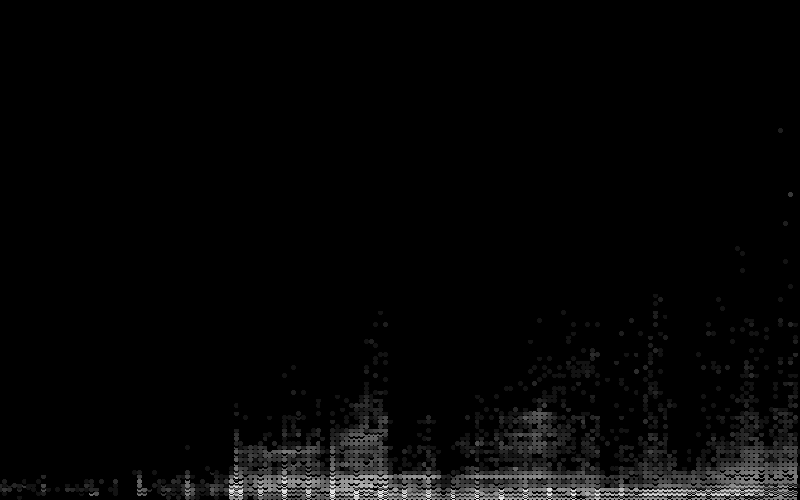

In [10]:
cvs = ds.Canvas(800, 500, x_range = (ny['YearBuilt'].min(), ny['YearBuilt'].max()), 
                                y_range = (ny['NumFloors'].min(), ny['NumFloors'].max()))
agg = cvs.points(ny, 'YearBuilt', 'NumFloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

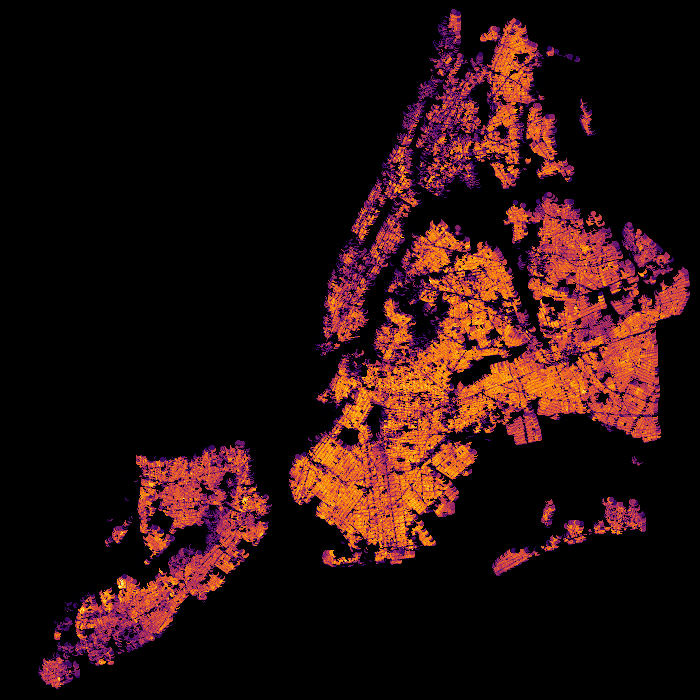

In [11]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their [github repo](https://github.com/bokeh/datashader/tree/master/examples). I would focus on the [visualization pipeline](https://anaconda.org/jbednar/pipeline/notebook) and the [US Census](https://anaconda.org/jbednar/census/notebook) Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

### Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

### Solution

Assessment of the structure is derived from the total assessment minus assessment of the land. A few entries assessed over one billion (unrealistic even for NYC) or missing assessment values are removed. Then each group - land and structure - is divided into 3 categories based on the spread - high, medium and low. Because the spread is too wide, assessment values are log transformed. 

Two groups are combined into potential 9 master categories which are then used for plotting. 

In [12]:
# Get assessment values from NYC data
df = ny[['lon', 'lat', 'AssessLand', 'AssessTot']]
df = df.assign(AssessStruct = df['AssessTot']-df['AssessLand'])

# Remove anything over $1,000,000,000
df = df.loc[(df['AssessTot']<1000000000) & (df['AssessTot']!=0)]

# Remove anything without value
df = df.loc[df['AssessStruct']!=0]

# Break land assessment into 3 categories - high, medium, low
df = df.assign(logAssessLand = np.log(df['AssessLand']))
df = df.assign(landCat = pd.cut(df['logAssessLand'], 
                                np.linspace(df['logAssessLand'].min()-0.1, df['logAssessLand'].max(), 4), 
                                labels=['Low', 'Medium', 'High']))

# Break structure assessment into 3 categories - high, medium, low
df = df.assign(logAssessStruct = np.log(df['AssessStruct']))
df = df.assign(structCat = pd.cut(df['logAssessStruct'], 
                                  np.linspace(df['logAssessStruct'].min()-0.1, df['logAssessStruct'].max(), 4), 
                                  labels=['Low', 'Medium', 'High']))

# Combine land and structure assessment categories
df = df.assign(LandStructCategory = df['landCat'].astype('str')+df['structCat'].astype('str'))
df['LandStructCategory'] = df['LandStructCategory'].astype('category')

df.groupby('LandStructCategory').size()

LandStructCategory
HighHigh          6302
HighLow              1
HighMedium         914
LowLow           14597
LowMedium        77764
MediumHigh        8076
MediumLow        14324
MediumMedium    689690
dtype: int64

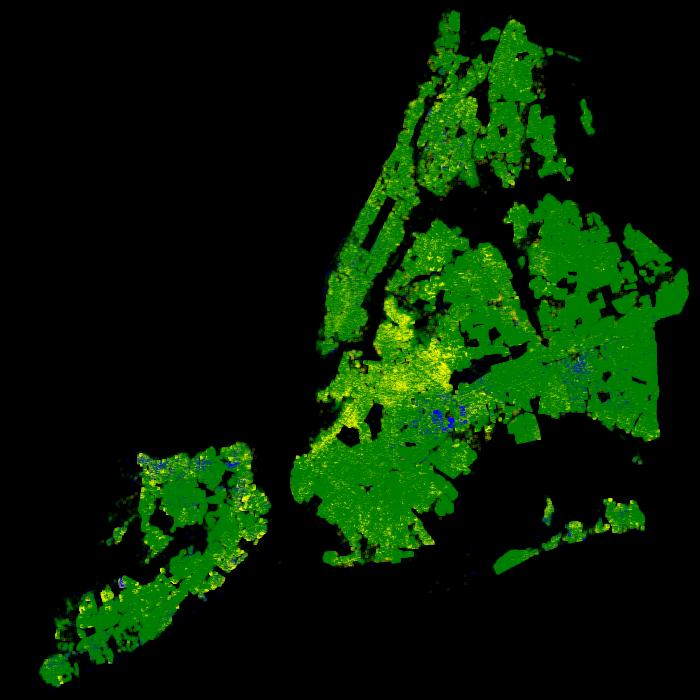

In [13]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(df, 'lon', 'lat', ds.count_cat('LandStructCategory'))
color_key = dict(HighHigh='green', HighMedium='blue', HighLow='blue', 
                 MediumHigh='yellow', MediumMedium='green', MediumLow='blue',
                 LowHigh='yellow', LowMedium='yellow', LowLow='green')                 
view = tf.shade(agg, color_key=color_key, how='log')
export(tf.spread(view, px=1), 'assessment')

Areas represented by **green** have land and structure assessments are in the same category - high/high, medium/medium or low/low. Areas represented by **blue** have land assessment higher than structure assessment (high/medium, high/low, medium/low). These are potentially underdeveloped areas - most prominently East New York and Jamaica. Areas represented by **yellow** have land assessment lower than structure assessment (low/medium, medium/high, low/high). These are potentially overdeveloped areas - especially North Brooklyn (Greenpoint, Williamsburg, Park Slope).